In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.init import _calculate_correct_fan

import torchvision
from torchvision import transforms

import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

import os
from collections import OrderedDict
from collections.abc import Mapping
import sys

sys.path.append('/Users/hyunsukim/Documents/GitHub/Paper-Study/Implicit_Neural_Representations/MetaSDF/metasdf')
from metasdf.torchmeta.modules import (MetaModule, MetaSequential, MetaLinear)
from metasdf.torchmeta.modules.utils import get_subdict

In [2]:
class BatchLinear(nn.Linear, MetaModule):
    def forward(self, input, params=None):
        if params is None:
            params = OrderedDict(self.named_parameters())
        
        bias = params.get('bias', None)
        weight = params['weight']

        output = input.matmul(weight.permute(*[i for i in range(len(weight.shape)-2)], -1, -2))
        output += bias.unsqueeze(-2)
        return output

class MetaFC(MetaModule):
    def __init__(self, in_features, out_features, num_hidden_layers,
                 hidden_features, outermost_linear=False):
        super().__init__()

        self.net = []
        self.net.append(MetaSequential(
            BatchLinear(in_features, hidden_features),
            nn.ReLU(inplace=True)
        ))

        for i in range(num_hidden_layers):
            self.net.append(MetaSequential(
                BatchLinear(hidden_features, hidden_features),
                nn.ReLU(inplace=True)
            ))
        
        if outermost_linear:
            self.net.append(MetaSequential(
                BatchLinear(hidden_features, out_features)
            ))
        else:
            self.net.append(MetaSequential(
                BatchLinear(hidden_features, out_features),
                nn.ReLU(inplace=True)
            ))

        self.net = MetaSequential(*self.net)
        self.net.apply(init_weights_normal)
    
    def forward(self, coords, params=None, **kwargs):
        output = self.net(coords, params=get_subdict(params, 'net'))
        return output

class SineLayer(MetaModule):
    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = float(omega_0)

        self.is_first = is_first
        self.in_features = in_features
        self.linear = BatchLinear(in_features, out_features, bias=bias)
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                            1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                            np.sqrt(6 / self.in_features) / self.omega_0)
    
    def forward(self, input, params=None):
        intermed = self.linear(input, params=get_subdict(params, 'linear'))
        return torch.sin(self.omega_0 * intermed)

class Siren(MetaModule):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features,
                 outermost_linear=False, first_omega_0=30, hidden_omega_0=30., special_first=True):
        super().__init__()
        self.hidden_omega_0 = hidden_omega_0

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=special_first, omega_0=first_omega_0))
        
        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))
        
        if outermost_linear:
            final_linear = BatchLinear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / 30.,
                                             np.sqrt(6 / hidden_features) / 30.)
            
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.ModuleList(self.net)
    
    def forward(self, coords, params=None):
        x = coords

        for i, layer in enumerate(self.net):
            x = layer(x, params=get_subdict(params, f'net.{i}'))
        
        return x


def init_weights_normal(m):
    if type(m) == BatchLinear or nn.Linear:
        if hasattr(m, 'weight'):
            torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if hasattr(m, 'bias'):
            m.bias.data.fill_(0.)

def get_mgrid(sidelen):
    # Generate 2D pixel coordinates from an image of sidelen x sidelen
    pixel_coords = np.stack(np.mgrid[:sidelen,:sidelen], axis=-1)[None,...].astype(np.float32)
    pixel_coords /= sidelen    
    pixel_coords -= 0.5
    pixel_coords = torch.Tensor(pixel_coords).view(-1, 2)
    return pixel_coords

In [3]:
def l2_loss(prediction, gt):
    return ((prediction - gt)**2).mean()


class MAML(nn.Module):
    def __init__(self, num_meta_steps, hypo_module, loss, init_lr,
                 lr_type='static', first_order=False):
        super().__init__()

        self.hypo_module = hypo_module # The module who's weights we want to meta-learn.
        self.first_order = first_order
        self.loss = loss
        self.lr_type = lr_type
        self.log = []

        self.register_buffer('num_meta_steps', torch.Tensor([num_meta_steps]).int())

        if self.lr_type == 'static': 
            self.register_buffer('lr', torch.Tensor([init_lr]))
        elif self.lr_type == 'global':
            self.lr = nn.Parameter(torch.Tensor([init_lr]))
        elif self.lr_type == 'per_step':
            self.lr = nn.ParameterList([nn.Parameter(torch.Tensor([init_lr]))
                                        for _ in range(num_meta_steps)])
        elif self.lr_type == 'per_parameter': # As proposed in "Meta-SGD".
            self.lr = nn.ParameterList([])
            hypo_parameters = hypo_module.parameters()
            for param in hypo_parameters:
                self.lr.append(nn.Parameter(torch.ones(param.size()) * init_lr))
        elif self.lr_type == 'per_parameter_per_step':
            self.lr = nn.ModuleList([])
            for name, param in hypo_module.meta_named_parameters():
                self.lr.append(nn.ParameterList([nn.Parameter(torch.ones(param.size()) * init_lr)
                                                 for _ in range(num_meta_steps)]))

        param_count = 0
        for param in self.parameters():
            param_count += np.prod(param.shape)

        print(param_count)

    def _update_step(self, loss, param_dict, step):
        grads = torch.autograd.grad(loss, param_dict.values(),
                                    create_graph=False if self.first_order else True)
        params = OrderedDict()
        for i, ((name, param), grad) in enumerate(zip(param_dict.items(), grads)):
            if self.lr_type in ['static', 'global']:
                lr = self.lr
                params[name] = param - lr * grad
            elif self.lr_type in ['per_step']:
                lr = self.lr[step]
                params[name] = param - lr * grad
            elif self.lr_type in ['per_parameter']:
                lr = self.lr[i]
                params[name] = param - lr * grad
            elif self.lr_type in ['per_parameter_per_step']:
                lr = self.lr[i][step]
                params[name] = param - lr * grad
            else:
                raise NotImplementedError

        return params, grads

    def forward_with_params(self, query_x, fast_params, **kwargs):
        output = self.hypo_module(query_x, params=fast_params)
        return output

    def generate_params(self, context_dict):
        """Specializes the model"""
        x = context_dict.get('x').to('mps')
        y = context_dict.get('y').to('mps')

        meta_batch_size = x.shape[0]

        with torch.enable_grad():
            # First, replicate the initialization for each batch item.
            # This is the learned initialization, i.e., in the outer loop,
            # the gradients are backpropagated all the way into the 
            # "meta_named_parameters" of the hypo_module.
            fast_params = OrderedDict()
            for name, param in self.hypo_module.meta_named_parameters():
                fast_params[name] = param[None, ...].repeat((meta_batch_size,) + (1,) * len(param.shape))

            prev_loss = 1e6
            intermed_predictions = []
            for j in range(self.num_meta_steps):
                # Using the current set of parameters, perform a forward pass with the context inputs.
                predictions = self.hypo_module(x, params=fast_params)

                # Compute the loss on the context labels.
                loss = self.loss(predictions, y)
                intermed_predictions.append(predictions)

                if loss > prev_loss:
                    print('inner lr too high?')
                
                # Using the computed loss, update the fast parameters.
                fast_params, grads = self._update_step(loss, fast_params, j)
                prev_loss = loss

        return fast_params, intermed_predictions

    def forward(self, meta_batch, **kwargs):
        # The meta_batch conists of the "context" set (the observations we're conditioning on)
        # and the "query" inputs (the points where we want to evaluate the specialized model)
        context = meta_batch['context']
        query_x = meta_batch['query']['x'].to('mps')

        # Specialize the model with the "generate_params" function.
        fast_params, intermed_predictions = self.generate_params(context)

        # Compute the final outputs.
        model_output = self.hypo_module(query_x, params=fast_params)
        out_dict = {'model_out':model_output, 'intermed_predictions':intermed_predictions}

        return out_dict

In [4]:
class CIFAR10():
    def __init__(self):
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        self.dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=transform)
        
        self.meshgrid = get_mgrid(sidelen=32)
    
    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, item):
        img, _ = self.dataset[item]
        img_flat = img.permute(1,2,0).view(-1, 3)
        return {'context':{'x':self.meshgrid, 'y':img_flat}, 
                'query':{'x':self.meshgrid, 'y':img_flat}}


def lin2img(tensor):
    batch_size, num_samples, channels = tensor.shape
    sidelen = np.sqrt(num_samples).astype(int)
    return tensor.view(batch_size, sidelen, sidelen, channels).squeeze(-1)

    
def plot_sample_image(img_batch, ax):
    img = lin2img(img_batch)[0].detach().cpu().numpy()
    img += 1
    img /= 2.
    img = np.clip(img, 0., 1.)
    ax.set_axis_off()
    ax.imshow(img)


def dict_to_gpu(ob):
    if isinstance(ob, Mapping):
        return {k: dict_to_gpu(v) for k, v in ob.items()}
    else:
        return ob.to('mps')    


def dict_to_gpu(ob):
    if isinstance(ob, Mapping):
        return {k: dict_to_gpu(v) for k, v in ob.items()}
    else:
        return ob.to('mps')    

In [5]:
img_siren = Siren(in_features=2, hidden_features=128, hidden_layers=3, out_features=3, outermost_linear=True).to('mps')
meta_siren = MAML(num_meta_steps=3, hypo_module=img_siren, loss=l2_loss, init_lr=1e-5, 
                  lr_type='per_parameter_per_step').to('mps')

dataset = CIFAR10()
dataloader = DataLoader(dataset, batch_size=32, num_workers=0)

201228
Files already downloaded and verified


In [6]:
steps_til_summary = 100

optim = torch.optim.Adam(lr=5e-5, params=meta_siren.parameters())

for step, sample in enumerate(dataloader):
    sample = dict_to_gpu(sample)
    model_output = meta_siren(sample)    
    loss = ((model_output['model_out'] - sample['query']['y'])**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        fig, axes = plt.subplots(1,5, figsize=(30,6))
        ax_titles = ['Learned Initialization', 'Inner step 1 output', 
                     'Inner step 2 output', 'Inner step 3 output', 
                     'Ground Truth']
        for i, inner_step_out in enumerate(model_output['intermed_predictions']):
            plot_sample_image(inner_step_out, ax=axes[i])
            axes[i].set_title(ax_titles[i], fontsize=25)
        plot_sample_image(model_output['model_out'], ax=axes[-2])
        axes[-2].set_title(ax_titles[-2], fontsize=25)

        plot_sample_image(sample['query']['y'], ax=axes[-1])
        axes[-1].set_title(ax_titles[-1], fontsize=25)

        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()


In [7]:
class SignedDistanceTransform:
    def __call__(self, img_tensor):
        # Threshold.
        img_tensor[img_tensor<0.5] = 0.
        img_tensor[img_tensor>=0.5] = 1.

        # Compute signed distances with distance transform
        img_tensor = img_tensor.numpy()

        neg_distances = scipy.ndimage.morphology.distance_transform_edt(img_tensor)
        sd_img = img_tensor - 1.
        sd_img = sd_img.astype(np.uint8)
        signed_distances = scipy.ndimage.morphology.distance_transform_edt(sd_img) - neg_distances
        signed_distances /= float(img_tensor.shape[1])
        signed_distances = torch.Tensor(signed_distances)

        return signed_distances, torch.Tensor(img_tensor)


class MNISTSDFDataset(torch.utils.data.Dataset):
    def __init__(self, split, size=(256,256)):
        self.transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
            SignedDistanceTransform(),
        ])
        self.img_dataset = torchvision.datasets.MNIST('./data/MNIST', train=True if split == 'train' else False,
                                                download=True)
        self.meshgrid = get_mgrid(size[0])
        self.im_size = size

    def __len__(self):
        return len(self.img_dataset)

    def __getitem__(self, item):
        img, digit_class = self.img_dataset[item]

        signed_distance_img, binary_image = self.transform(img)
        
        coord_values = self.meshgrid.reshape(-1, 2)
        signed_distance_values = signed_distance_img.reshape((-1, 1))
        
        indices = torch.randperm(coord_values.shape[0])
        support_indices = indices[:indices.shape[0]//2]
        query_indices = indices[indices.shape[0]//2:]

        meta_dict = {'context': {'x':coord_values[support_indices], 'y':signed_distance_values[support_indices]}, 
                     'query': {'x':coord_values[query_indices], 'y':signed_distance_values[query_indices]}, 
                     'all': {'x':coord_values, 'y':signed_distance_values}}

        return meta_dict

In [8]:
train_dataset = MNISTSDFDataset('train', size=(64, 64))
val_dataset = MNISTSDFDataset('val', size=(64, 64))

train_dataloader = DataLoader(train_dataset, batch_size=16)
val_dataloader = DataLoader(val_dataset, batch_size=16)

In [9]:
def sdf_loss(prediction, gt):
    return ((prediction - gt)**2).mean()

def inner_maml_sdf_loss(prediction, gt):
    return ((prediction - gt) ** 2).sum(0).mean()

In [10]:
def sal_init(m):
    if type(m) == BatchLinear or nn.Linear:
        if hasattr(m, 'weight'):
            std = np.sqrt(2) / np.sqrt(_calculate_correct_fan(m.weight, 'fan_out'))

            with torch.no_grad():
                m.weight.normal_(0., std)
        if hasattr(m, 'bias'):
            m.bias.data.fill_(0.0)


def sal_init_last_layer(m):
    if hasattr(m, 'weight'):
        val = np.sqrt(np.pi) / np.sqrt(_calculate_correct_fan(m.weight, 'fan_in'))
        with torch.no_grad():
            m.weight.fill_(val)
    if hasattr(m, 'bias'):
        m.bias.data.fill_(0.0)

In [11]:
hypo_module = MetaFC(in_features=2, out_features=1, 
                     num_hidden_layers=2, hidden_features=256, 
                     outermost_linear=True)
hypo_module.apply(sal_init)
hypo_module.net[-1].apply(sal_init_last_layer)
model = MAML(num_meta_steps=3, hypo_module=hypo_module, loss=inner_maml_sdf_loss, init_lr=1e-5, 
             lr_type='global').to('mps')

# img_siren = Siren(in_features=2, hidden_features=128, hidden_layers=3, out_features=1, outermost_linear=True).to('mps')
# model = MAML(num_meta_steps=3, hypo_module=img_siren, loss=inner_maml_sdf_loss, init_lr=1e-5, 
#                   lr_type='per_parameter_per_step').to('mps')

132610


/var/folders/m3/gc3jv3513p9b_6y82p_46vmw0000gn/T/ipykernel_43450/1609061876.py:10: DeprecationWarning: Please import `distance_transform_edt` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  neg_distances = scipy.ndimage.morphology.distance_transform_edt(img_tensor)
/var/folders/m3/gc3jv3513p9b_6y82p_46vmw0000gn/T/ipykernel_43450/1609061876.py:13: DeprecationWarning: Please import `distance_transform_edt` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  signed_distances = scipy.ndimage.morphology.distance_transform_edt(sd_img) - neg_distances


Step 0, Total loss 0.094387


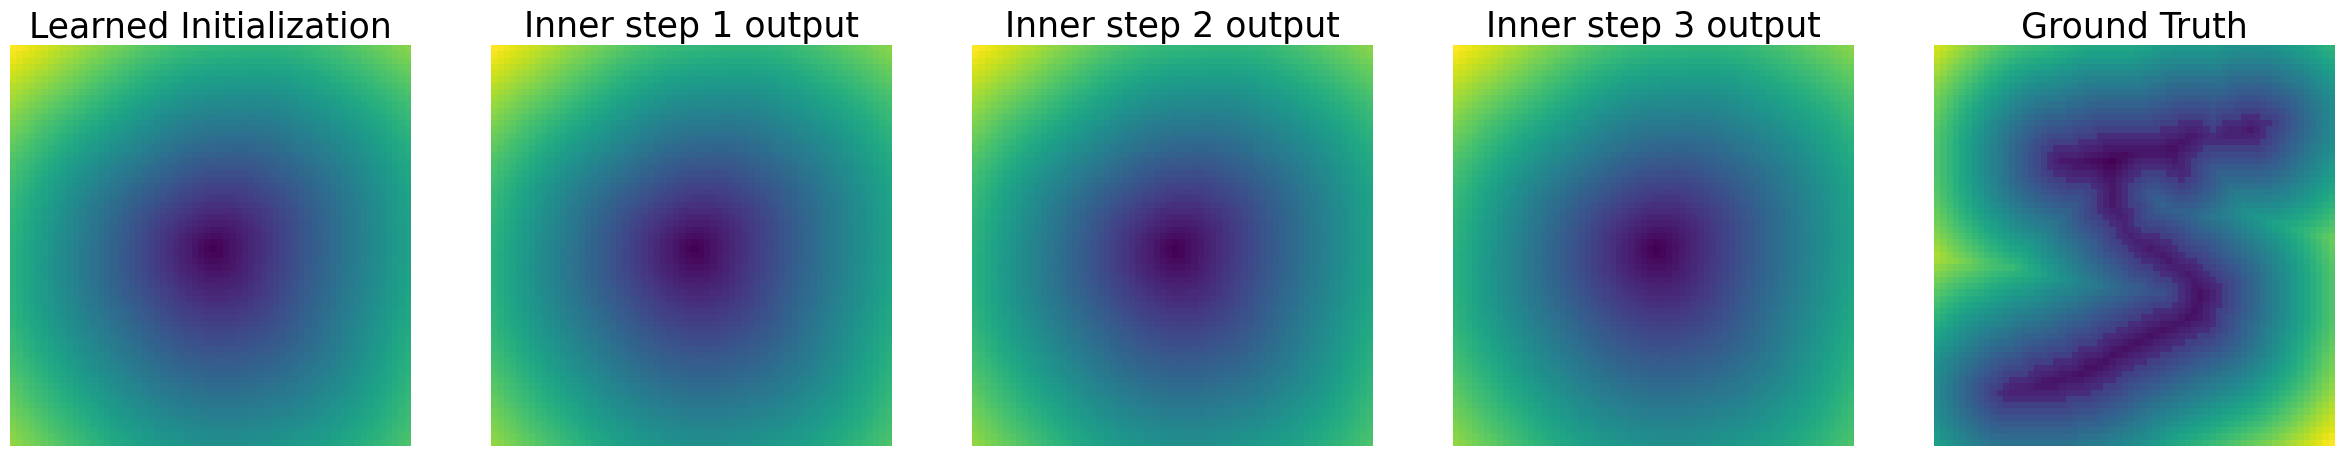

Step 100, Total loss 0.005440


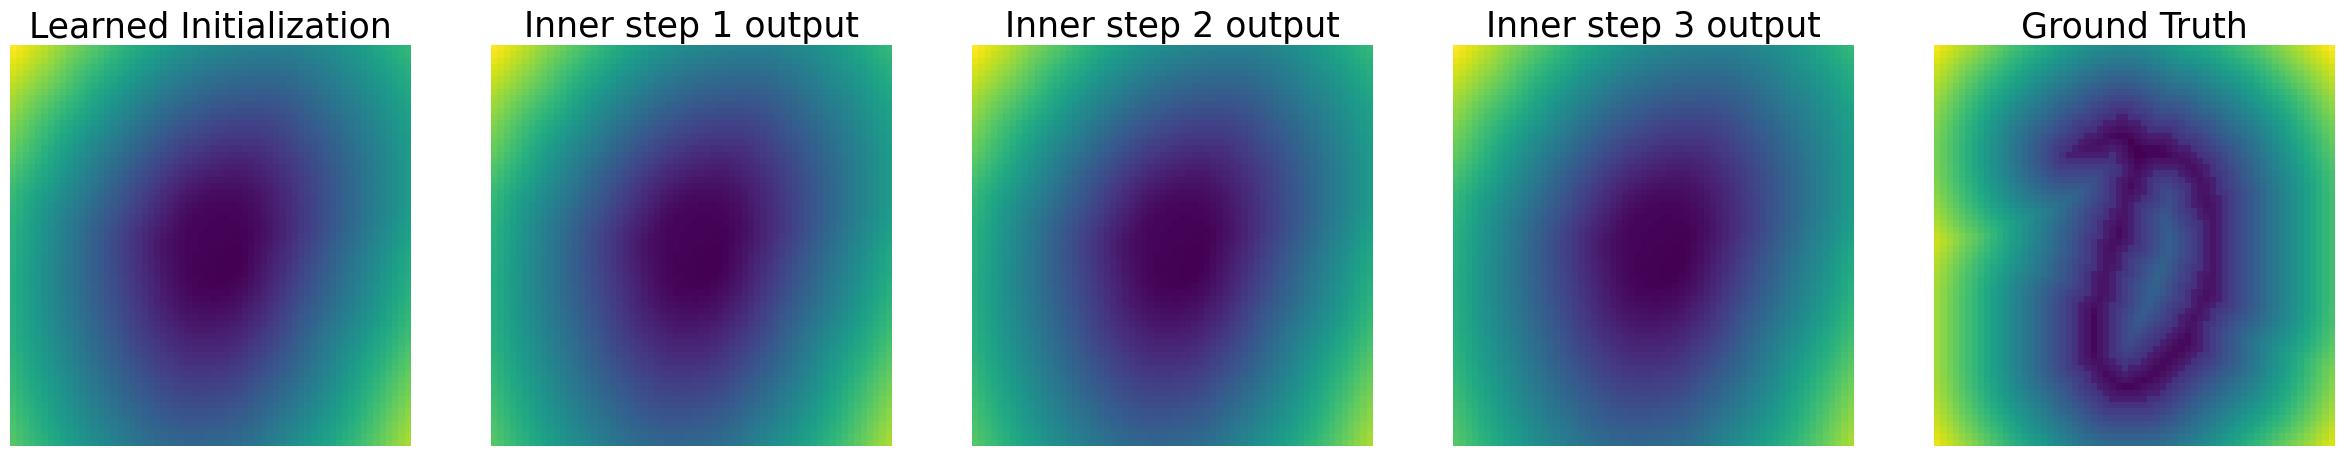

Step 200, Total loss 0.004994


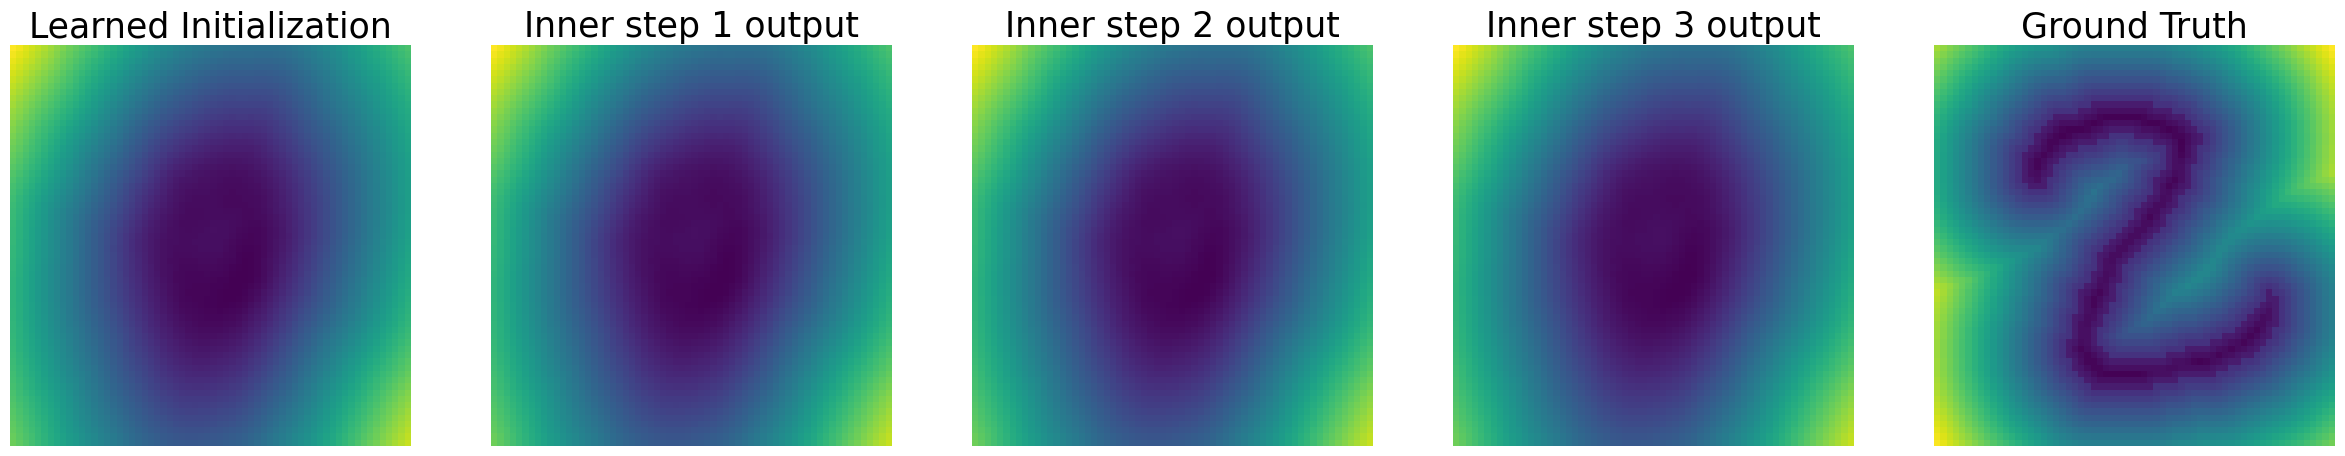

Step 300, Total loss 0.005147


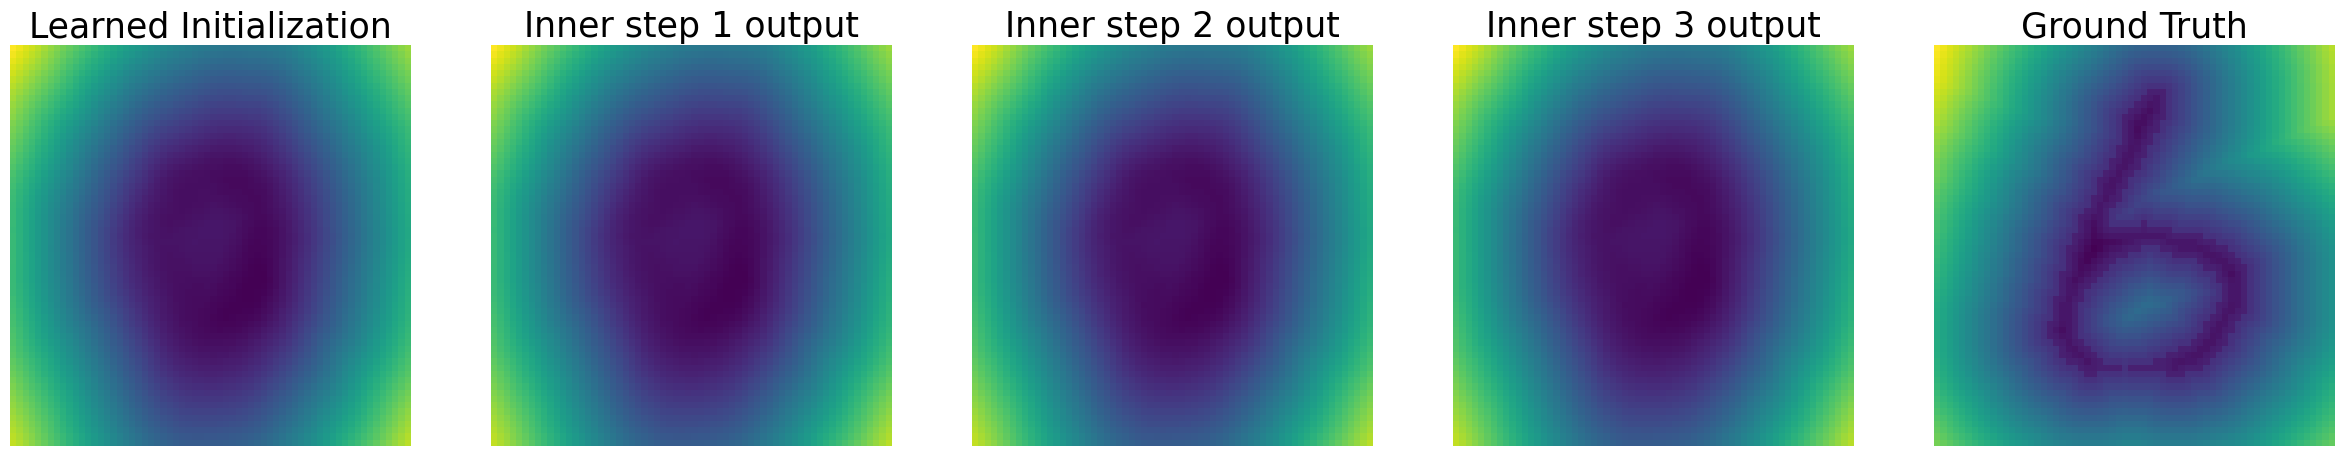

Step 400, Total loss 0.004608


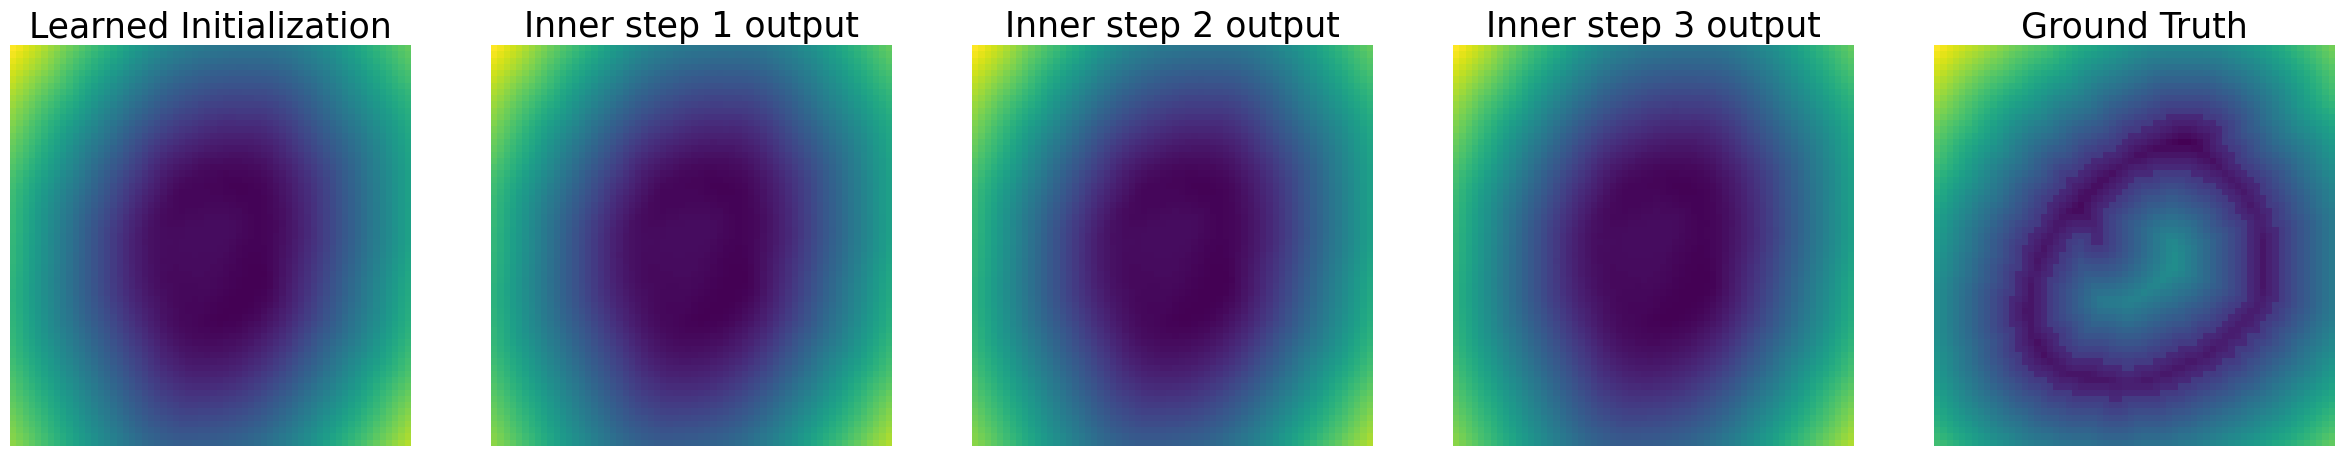

Step 500, Total loss 0.004619


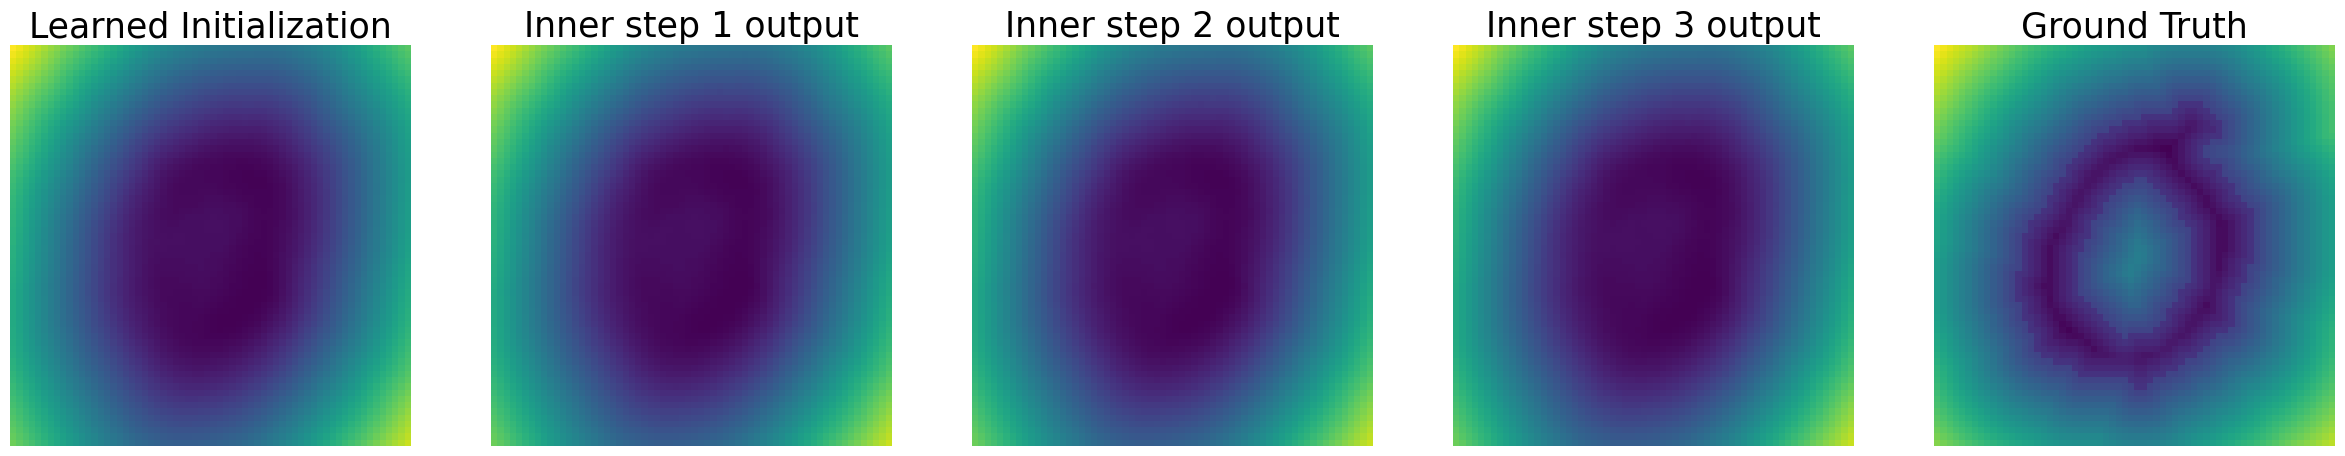

Step 600, Total loss 0.005033


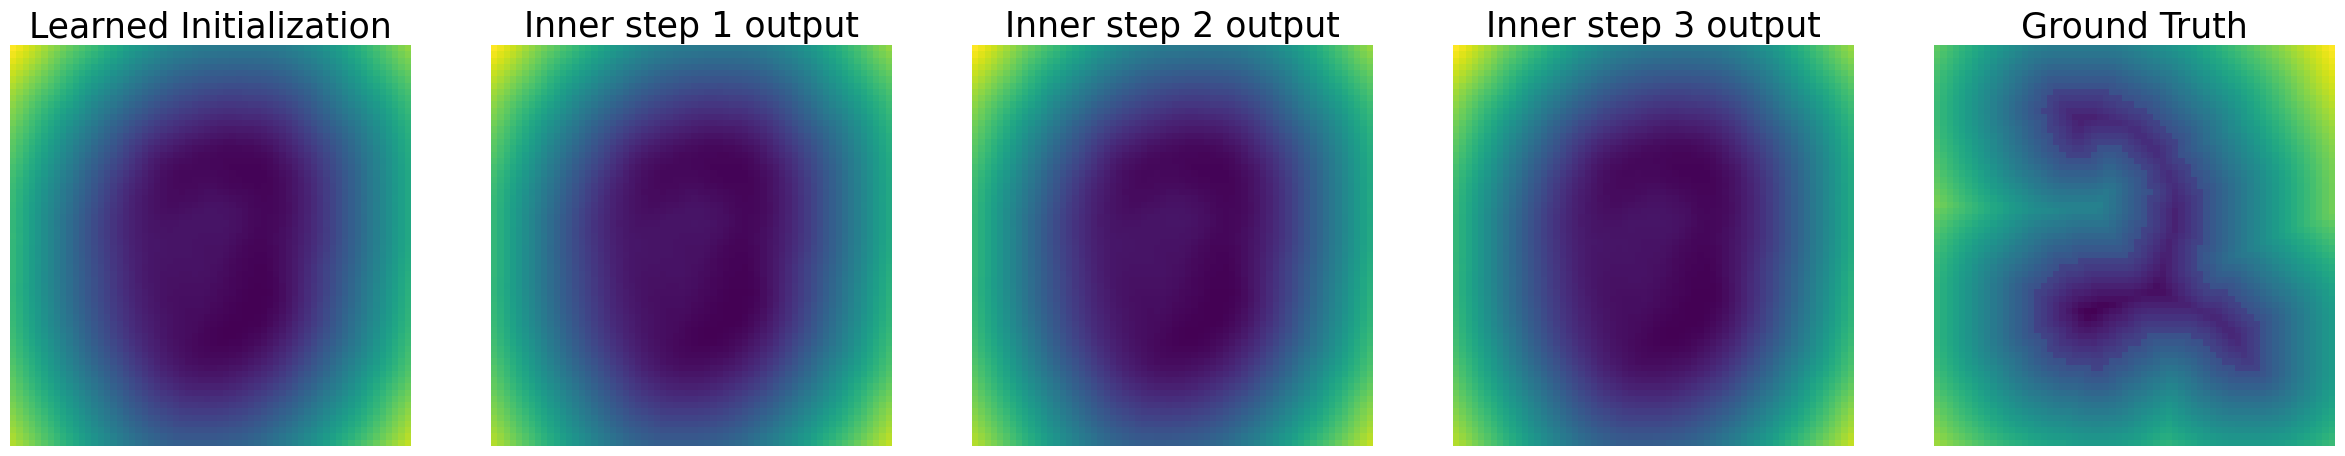

Step 700, Total loss 0.004079


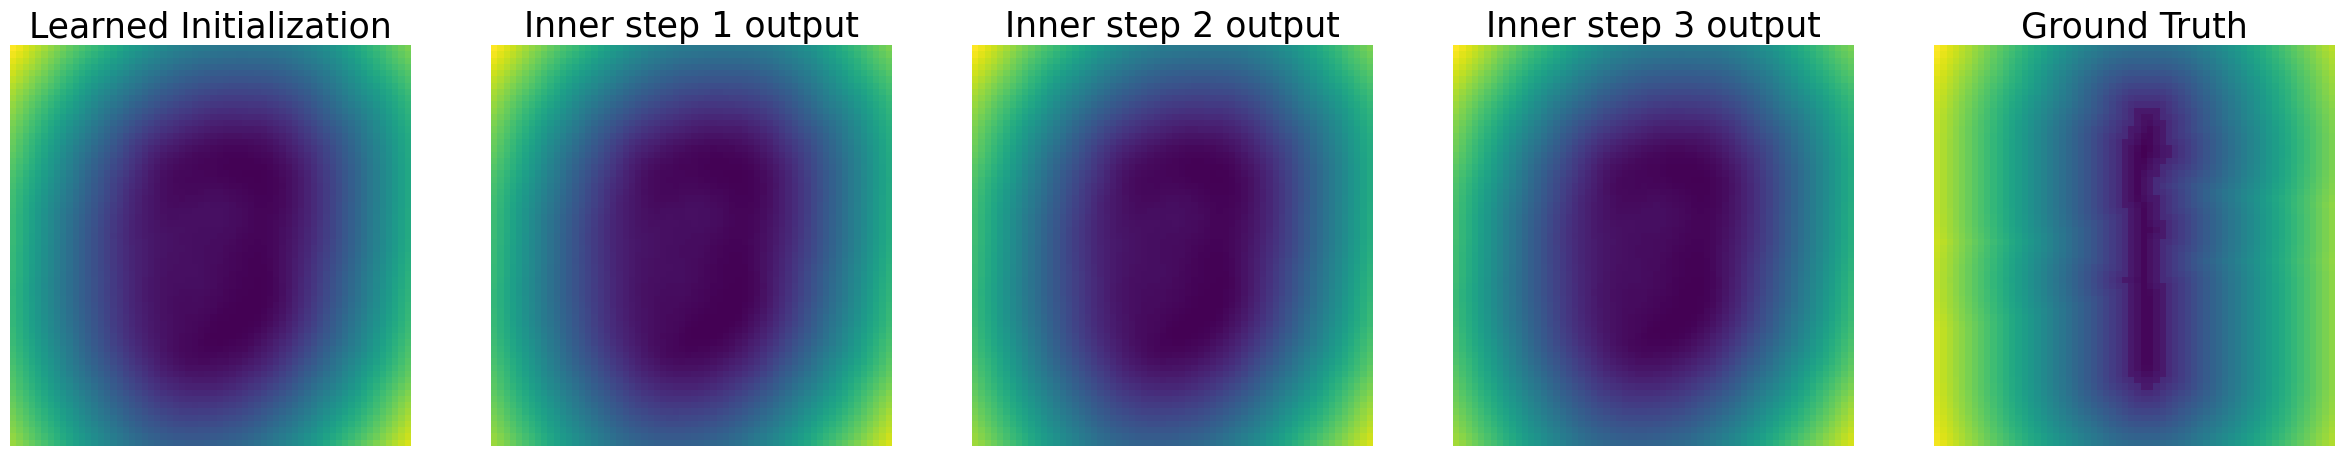

Step 800, Total loss 0.004470


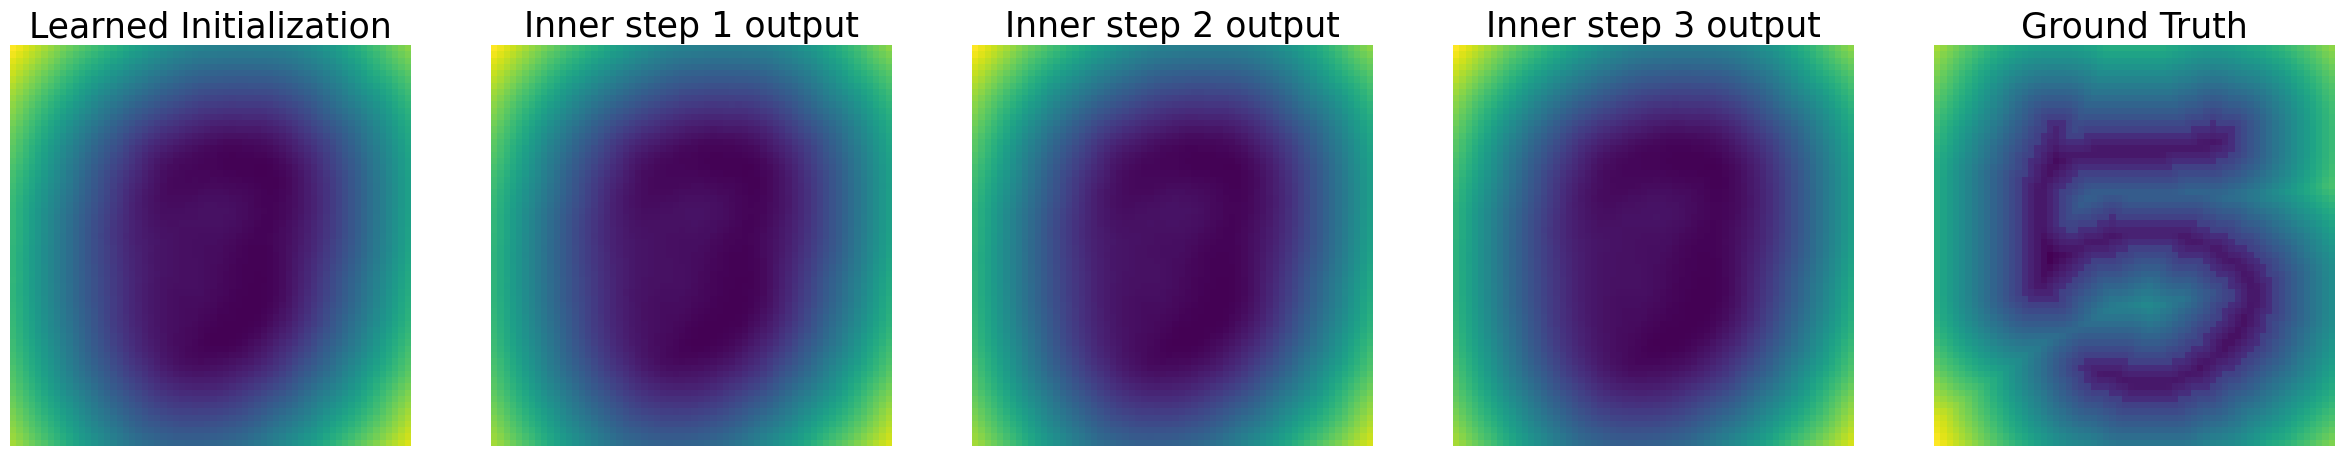

Step 900, Total loss 0.003523


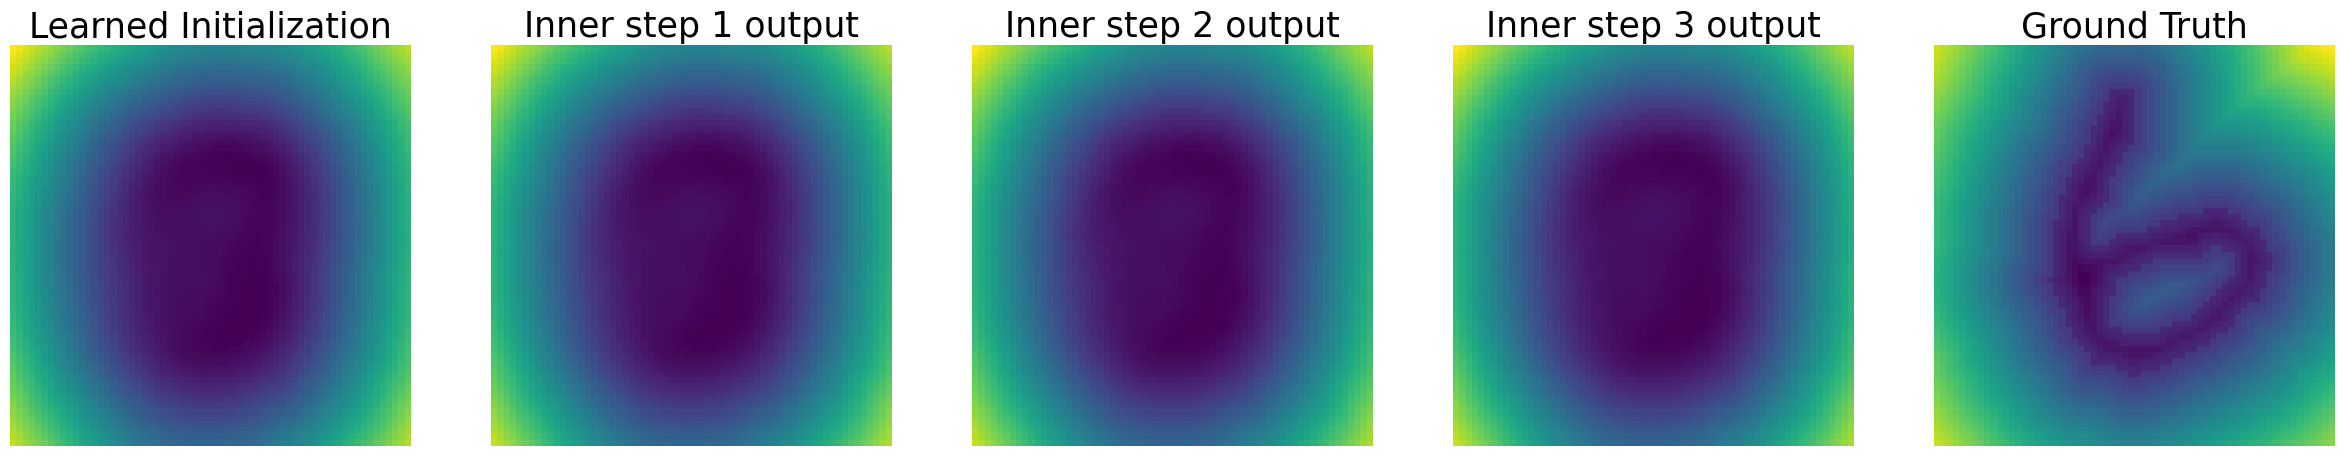

Step 1000, Total loss 0.003308


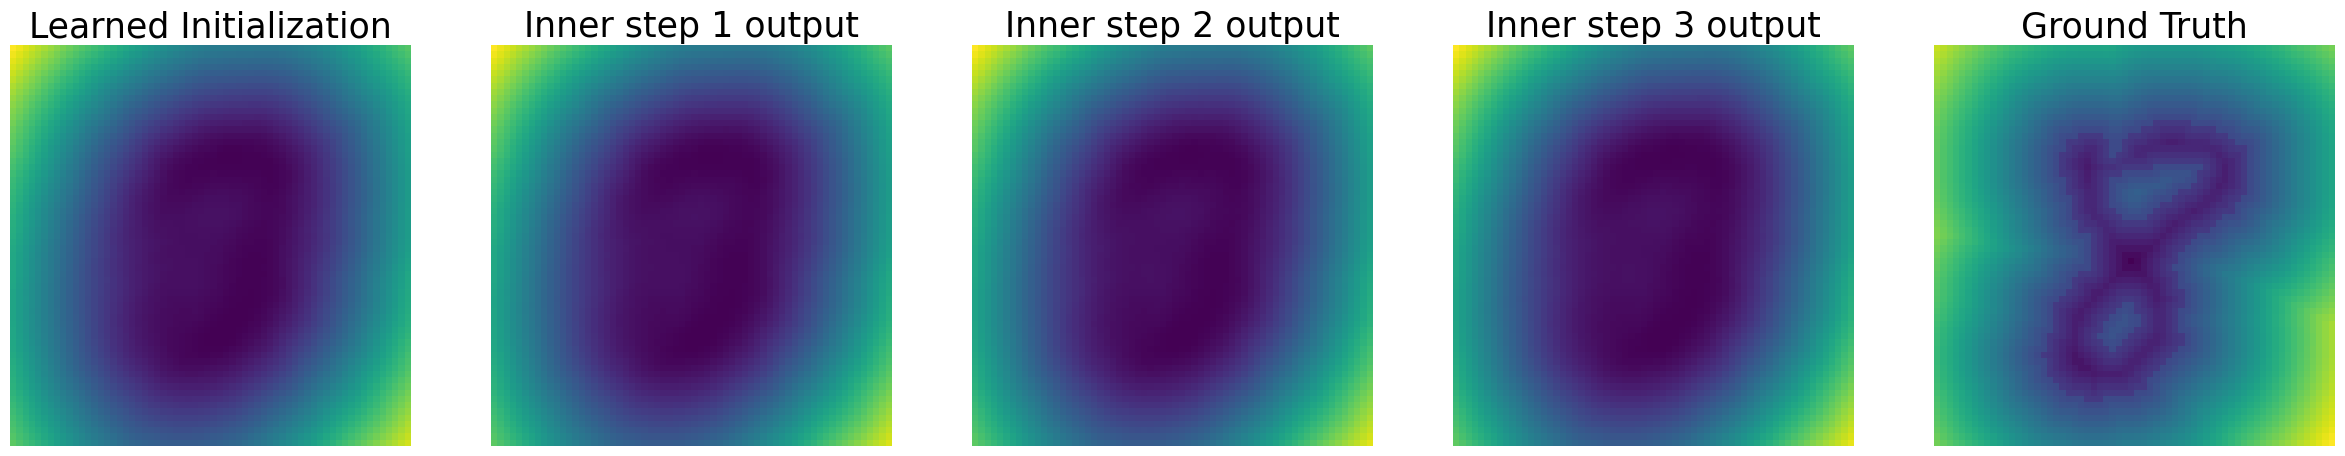

Step 1100, Total loss 0.003784


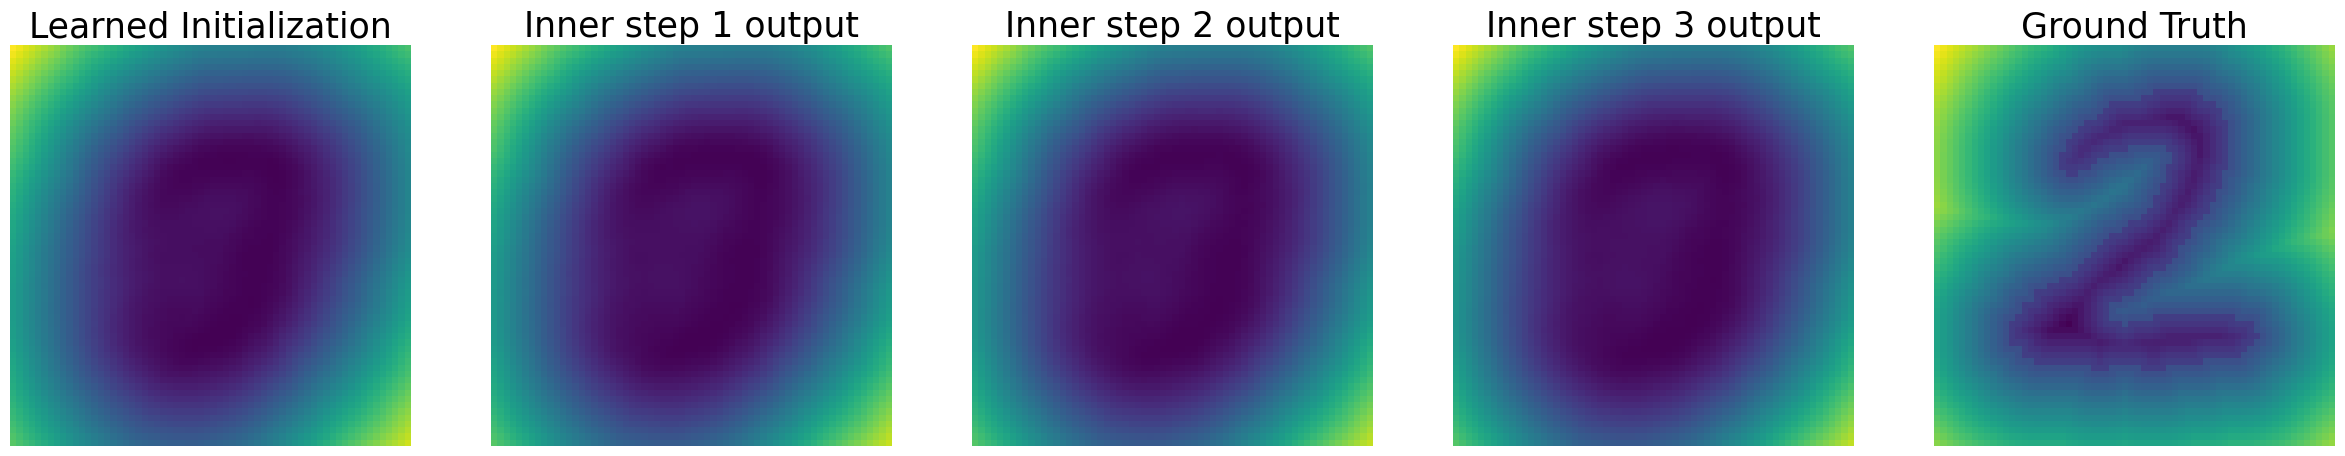

Step 1200, Total loss 0.002960


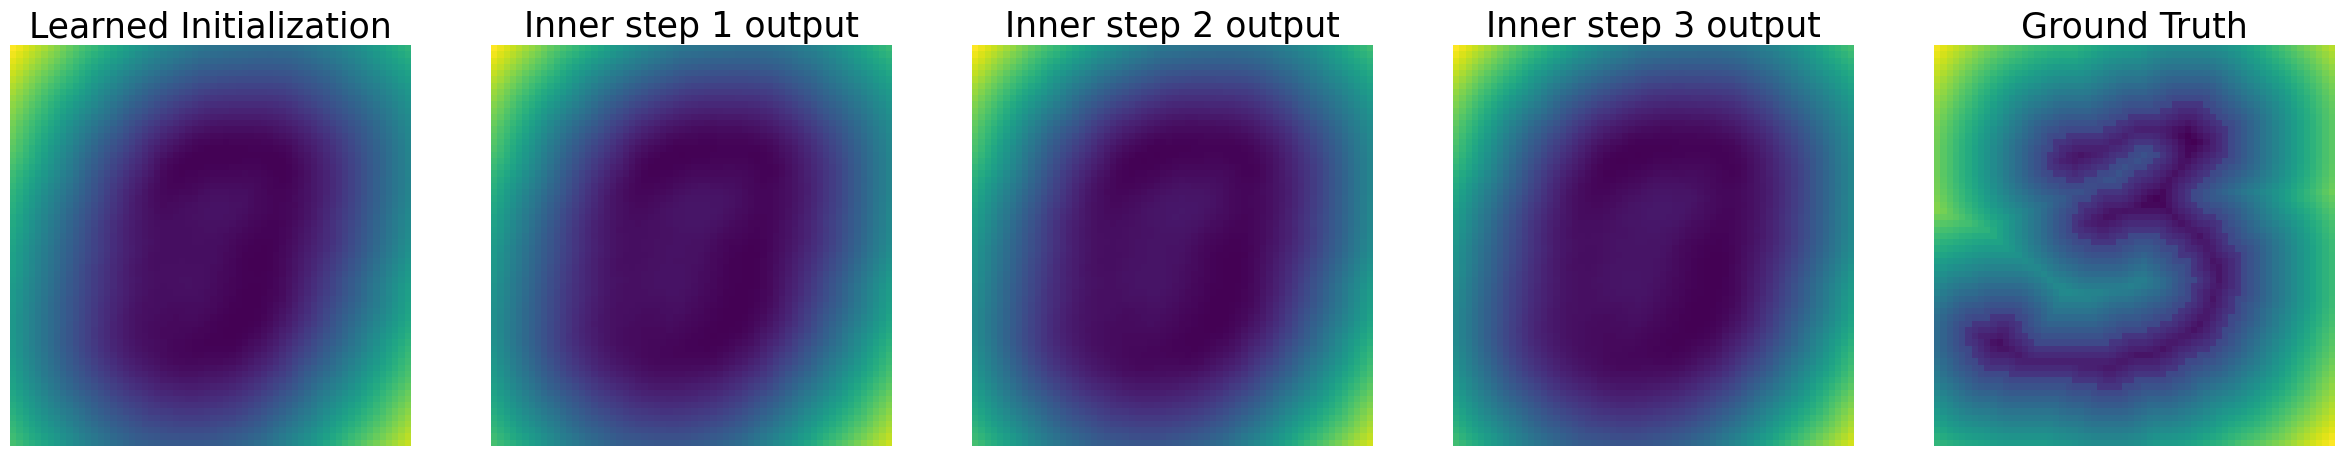

Step 1300, Total loss 0.002045


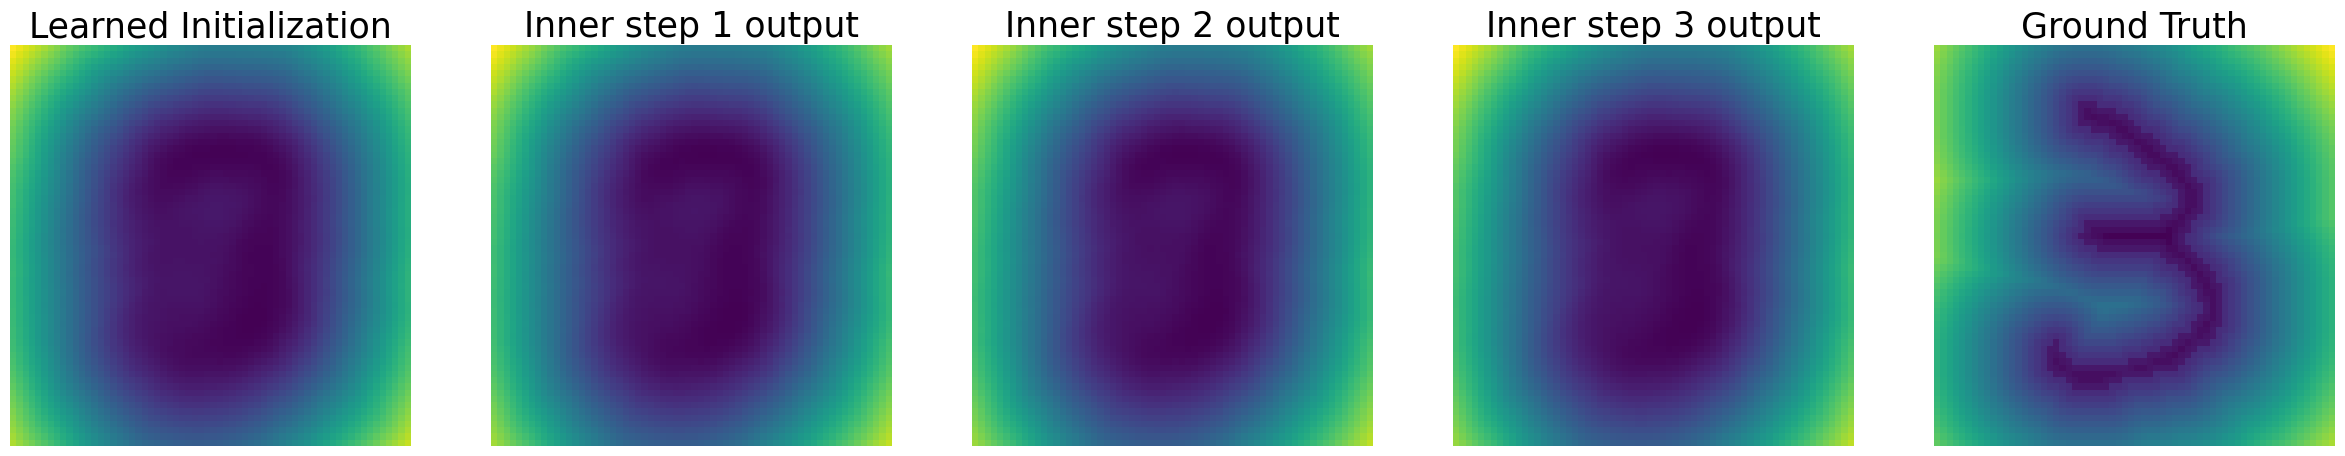

Step 1400, Total loss 0.002571


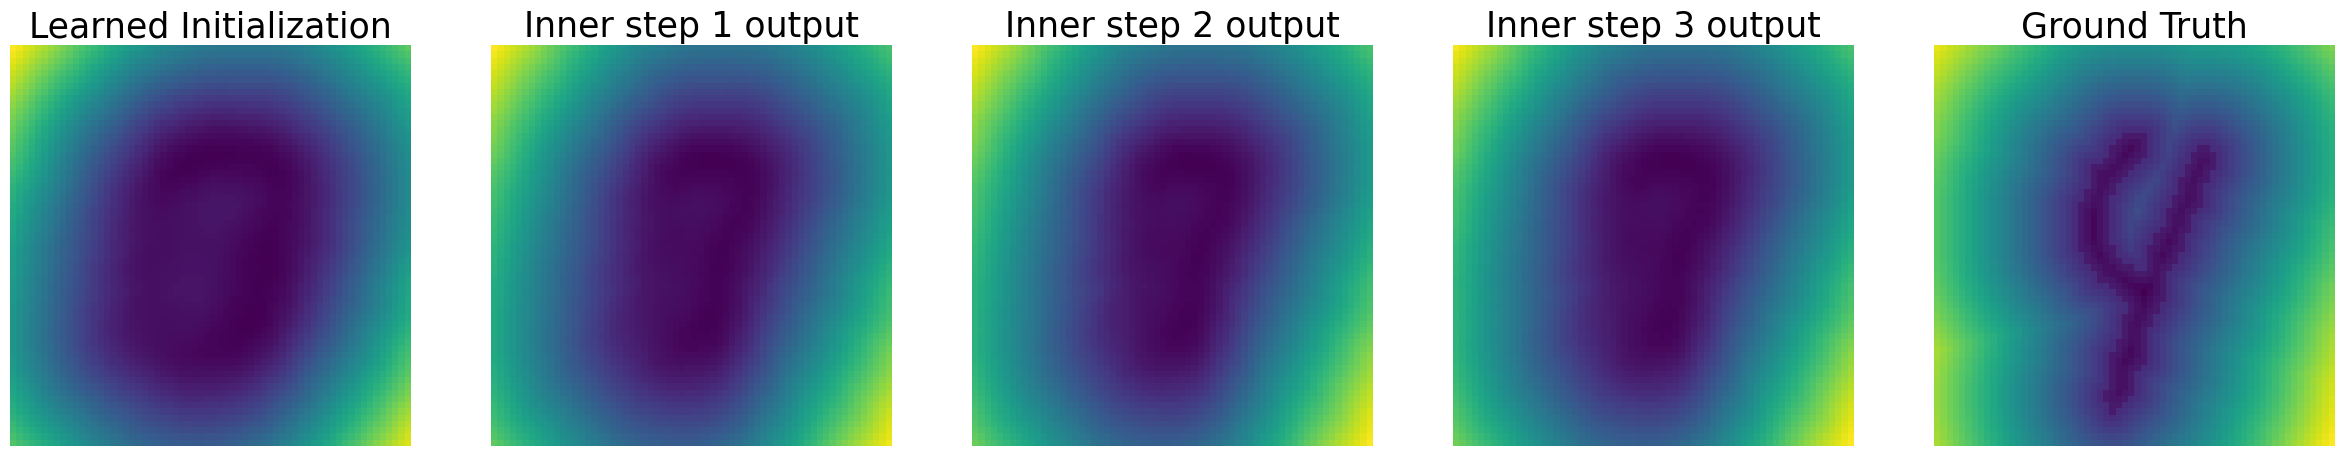

Step 1500, Total loss 0.002368


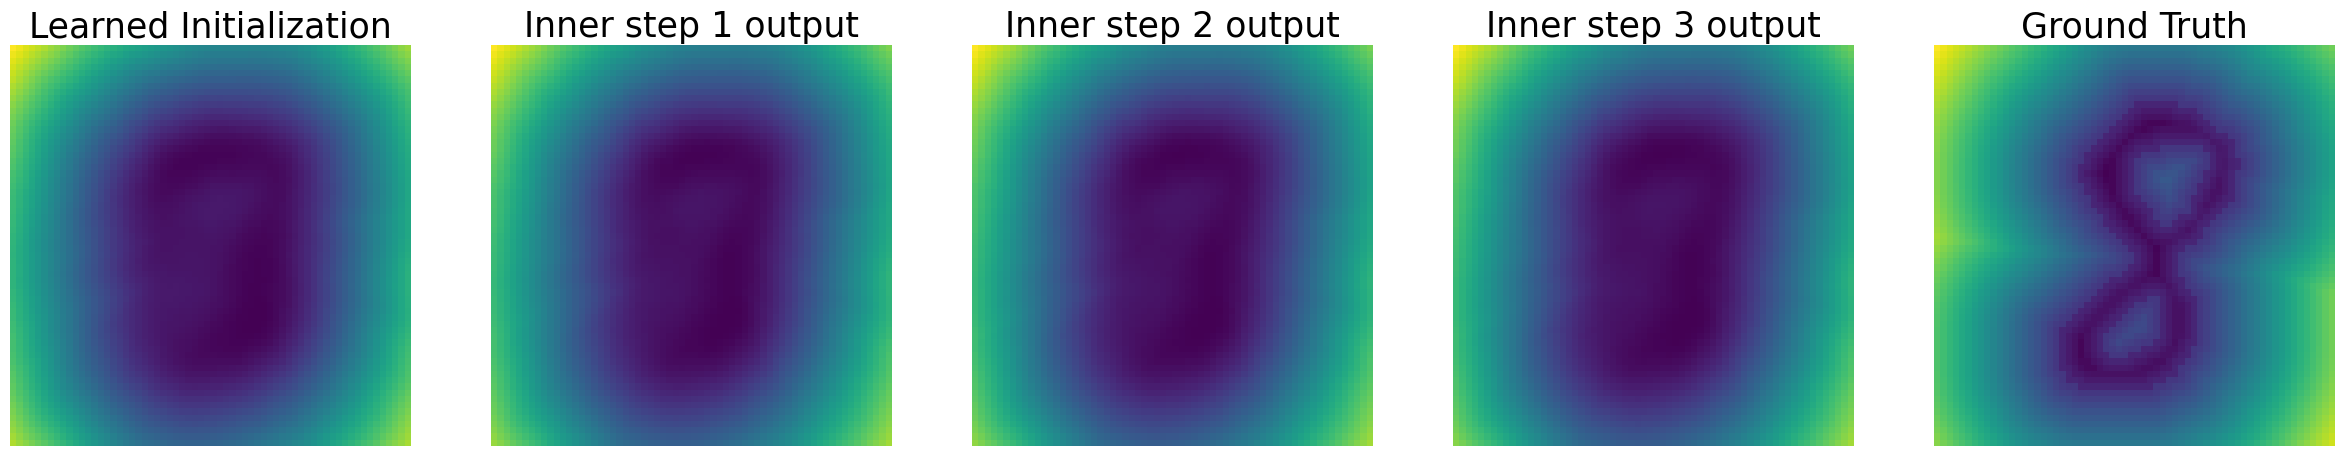

Step 1600, Total loss 0.001997


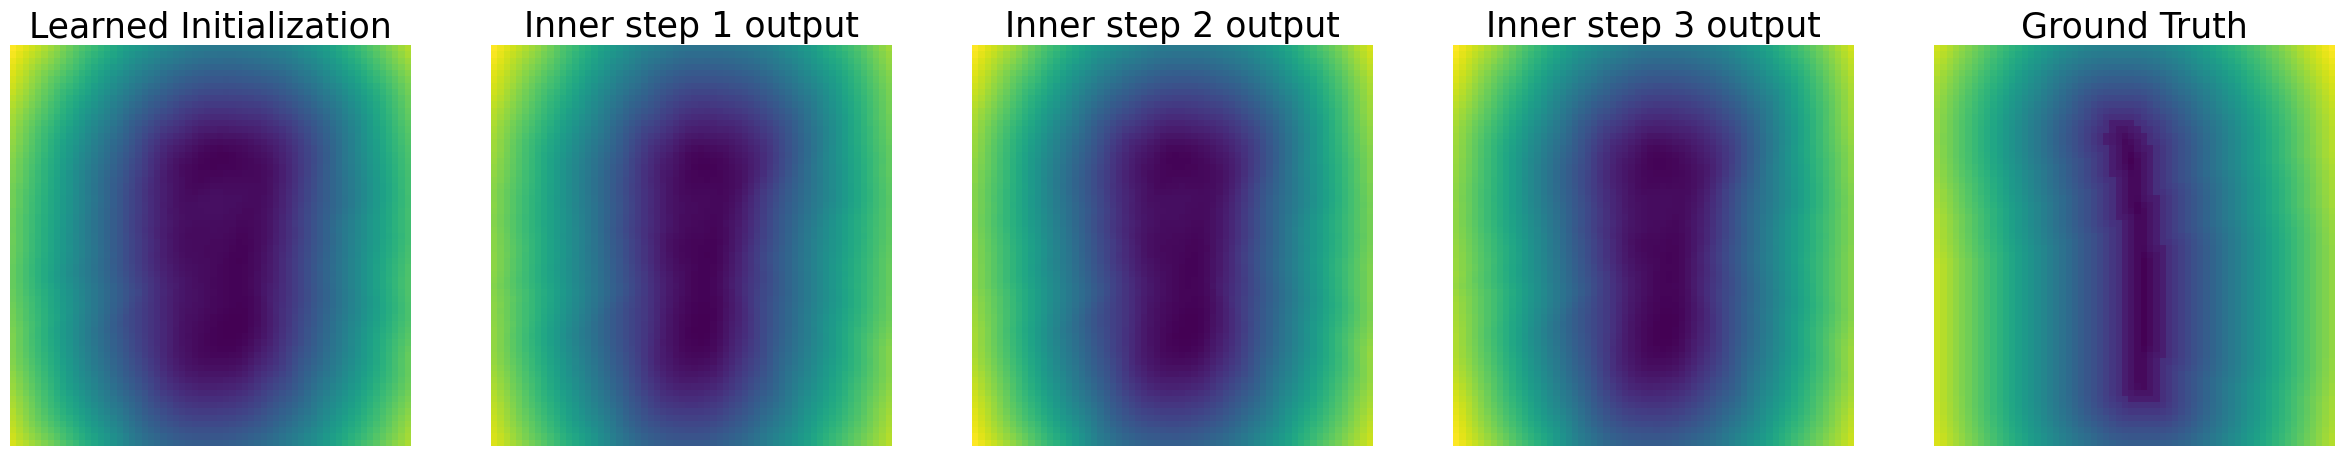

Step 1700, Total loss 0.001510


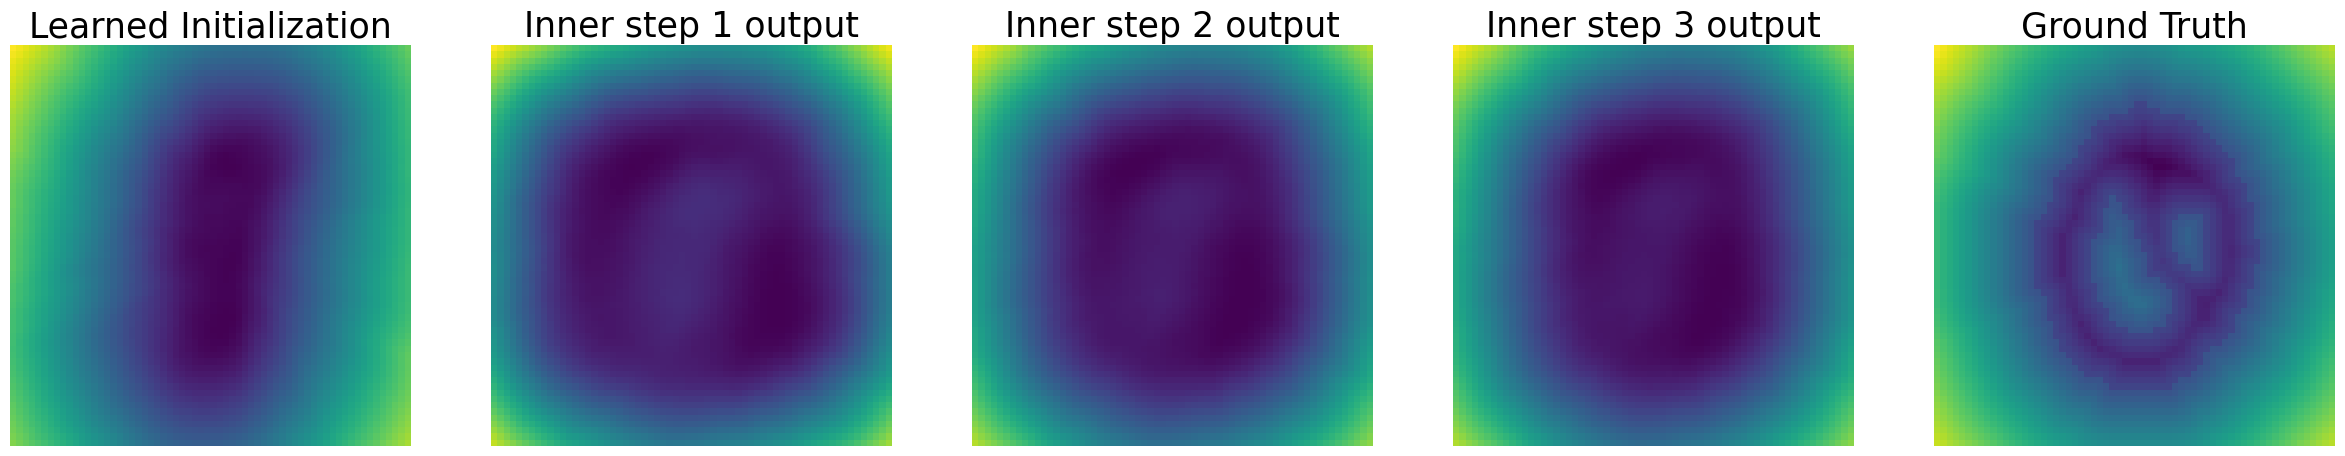

Step 1800, Total loss 0.001610


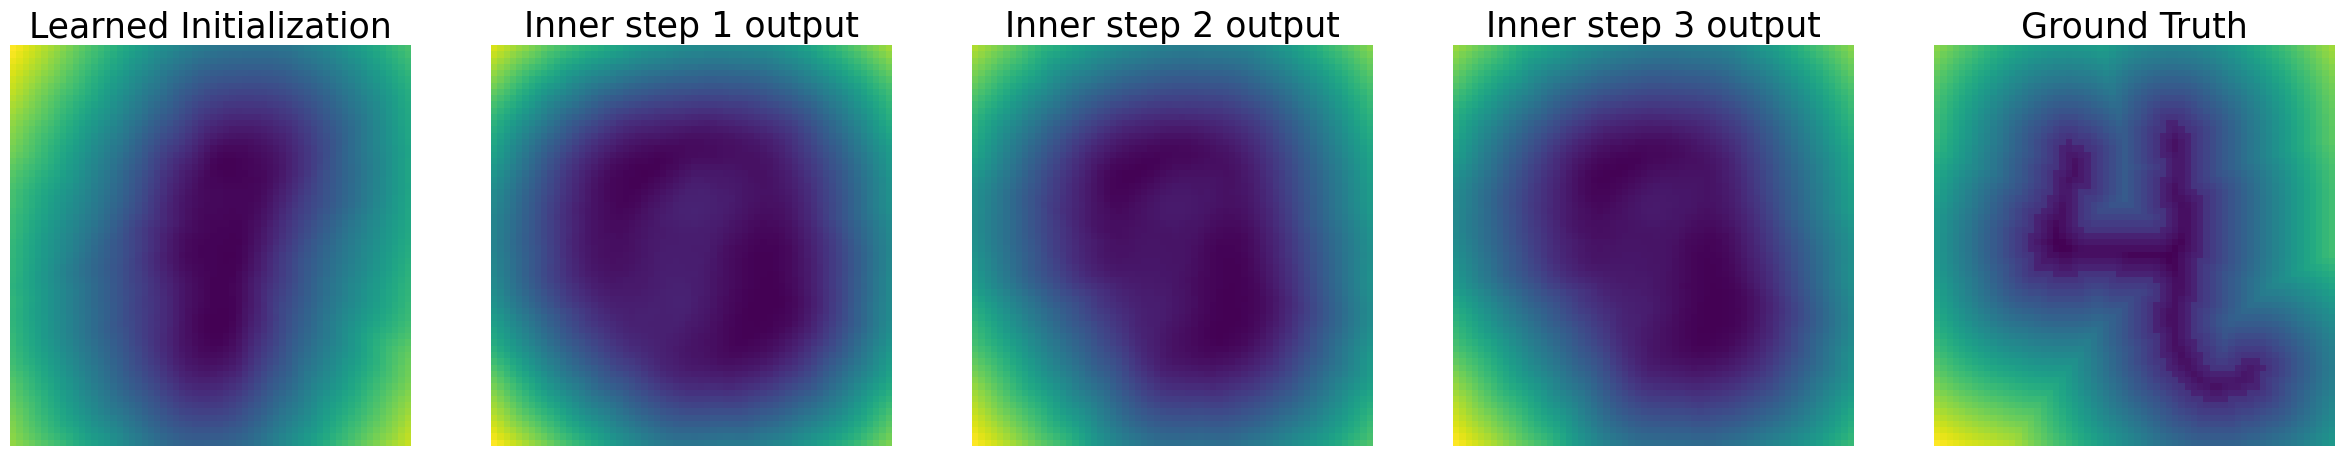

Step 1900, Total loss 0.001110


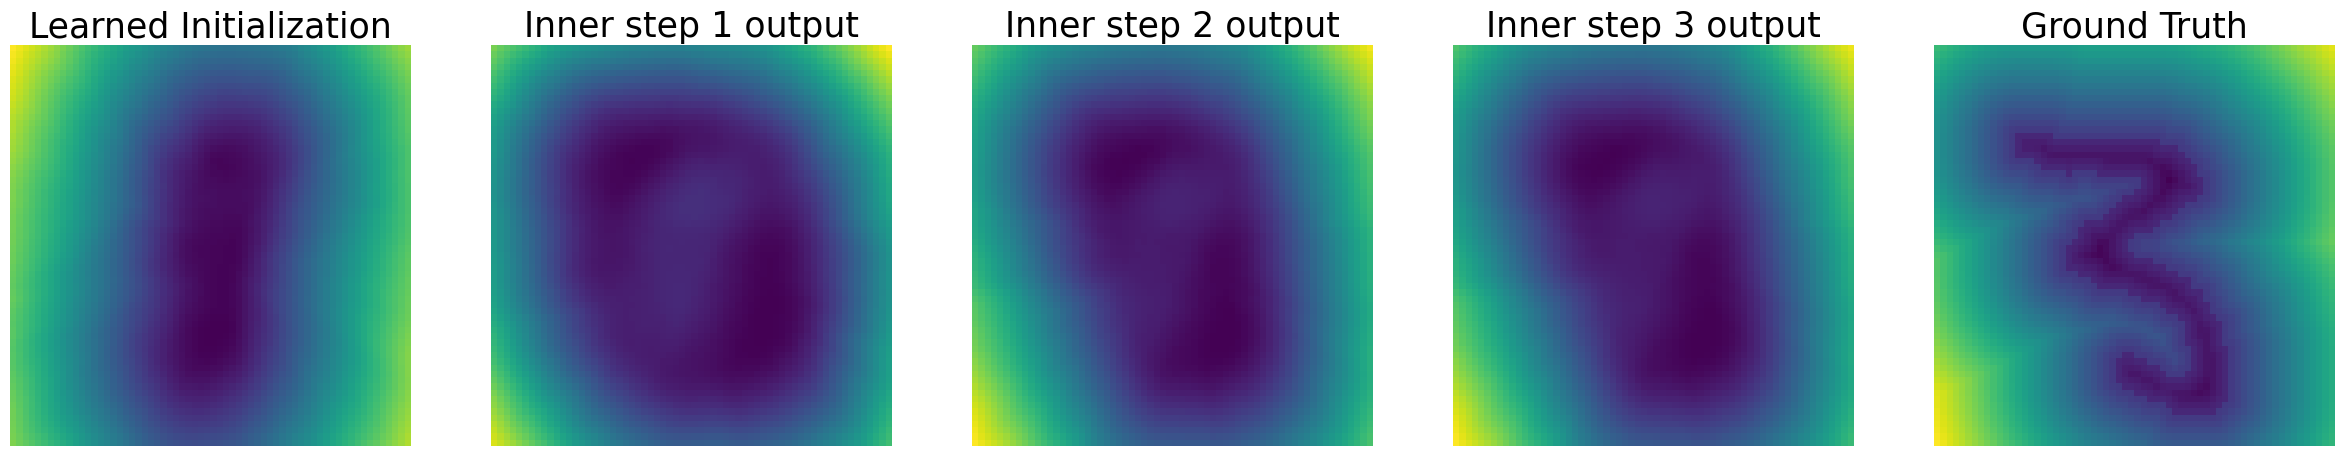

Step 2000, Total loss 0.001567


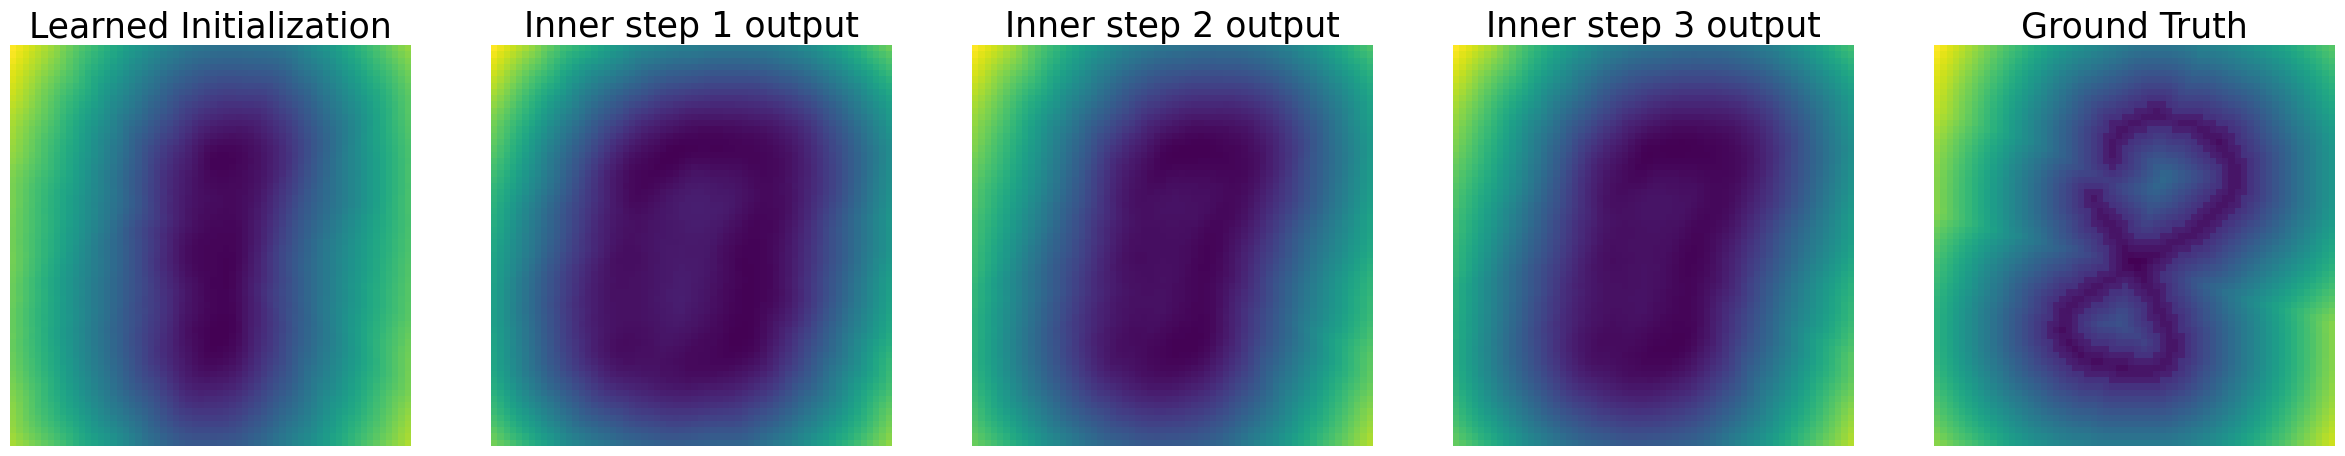

Step 2100, Total loss 0.001339


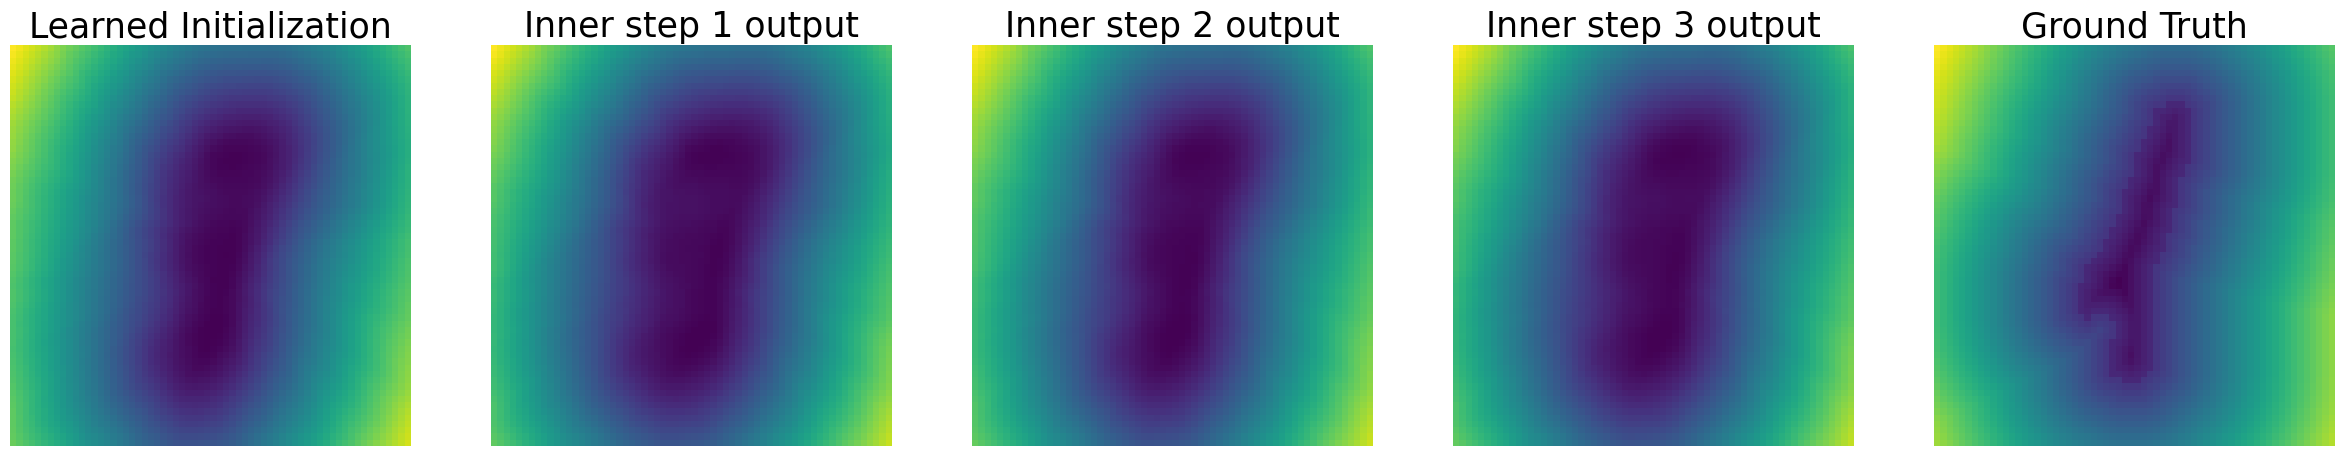

Step 2200, Total loss 0.001211


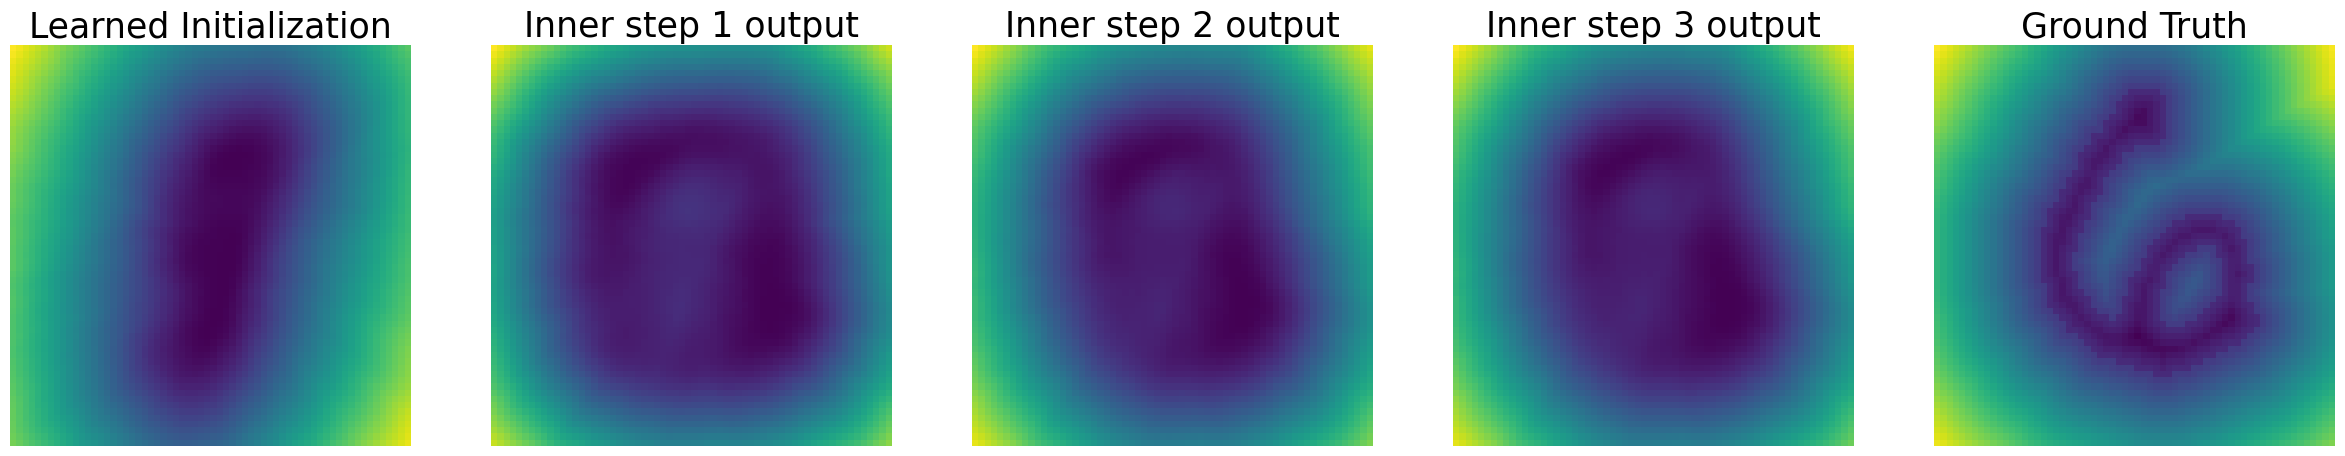

KeyboardInterrupt: 

In [12]:
optim = torch.optim.Adam(lr=1e-4, params=model.parameters())

train_losses = []
val_losses = []

for epoch in range(3):
    for step, meta_batch in enumerate(train_dataloader):
        model.train()        
        meta_batch = dict_to_gpu(meta_batch)

        # Adapt model using context examples
        fast_params, _ = model.generate_params(meta_batch['context'])
        
        # Use the adapted examples to make predictions on query
        pred_sd = model.forward_with_params(meta_batch['query']['x'], fast_params)
        
        # Calculate loss on query examples
        loss = sdf_loss(pred_sd, meta_batch['query']['y'].to('mps'))
        train_losses.append(loss.item())

        optim.zero_grad()
        loss.backward()
        optim.step()

        if step % 100 == 0:
            # Assemble validation input
            meta_batch['context']['x'] = meta_batch['query']['x'] = meta_batch['all']['x']
            meta_batch['context']['y'] = meta_batch['query']['y'] = meta_batch['all']['y']

            with torch.no_grad():
                model_output = model(meta_batch)

            print("Step %d, Total loss %0.6f" % (step, loss))
            fig, axes = plt.subplots(1,5, figsize=(30,6))
            ax_titles = ['Learned Initialization', 'Inner step 1 output', 
                        'Inner step 2 output', 'Inner step 3 output', 
                        'Ground Truth']
            for i, inner_step_out in enumerate(model_output['intermed_predictions']):
                
                plot_sample_image(inner_step_out, ax=axes[i])
                axes[i].set_axis_off()
                axes[i].set_title(ax_titles[i], fontsize=25)
            plot_sample_image(model_output['model_out'], ax=axes[-2])
            axes[-2].set_axis_off()
            axes[-2].set_title(ax_titles[-2], fontsize=25)

            plot_sample_image(meta_batch['query']['y'], ax=axes[-1])
            axes[-1].set_axis_off()
            axes[-1].set_title(ax_titles[-1], fontsize=25)
            plt.show()


In [ ]:
torch.randperm(50).sum()

In [ ]:
dataset = torchvision.datasets.MNIST('./data/MNIST', train=True, download=True)

In [ ]:
img_tensor = transforms.Resize((64, 64))(transforms.ToTensor()(dataset[0][0]))
print(img_tensor.shape)
img_tensor[img_tensor < 0.5] = 0.
img_tensor[img_tensor >= 0.5] = 1.
img_tensor = img_tensor.numpy()
plt.imshow(img_tensor[0])

In [ ]:
neg_distances = scipy.ndimage.morphology.distance_transform_edt(img_tensor)
print(neg_distances.min(), neg_distances.max(), neg_distances.mean())
plt.imshow(neg_distances[0])

In [ ]:
sd_img = img_tensor - 1.
sd_img = sd_img.astype(np.uint8)
print(sd_img.min(), sd_img.max(), sd_img.mean())
plt.imshow(sd_img[0])

In [ ]:
signed_distances = scipy.ndimage.morphology.distance_transform_edt(sd_img)
print(signed_distances.mean(), signed_distances.min(), signed_distances.max())
plt.imshow(signed_distances[0])

In [ ]:
signed_distances = signed_distances - neg_distances
print(signed_distances.mean(), signed_distances.min(), signed_distances.max())
plt.imshow(signed_distances[0])

In [ ]:
signed_distances /= float(img_tensor.shape[1])
print(signed_distances.mean(), signed_distances.min(), signed_distances.max())
plt.imshow(signed_distances[0])